<a href="https://colab.research.google.com/github/jamile-kellensouza/A-machine-learning-workflow-for-biomedical-tabular-data/blob/main/Agglomerative_HierarchicalClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pearsonr, pointbiserialr
! pip install gower
import gower
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('/content/alzheimers_disease_data.csv')

In [ ]:
data_fil = data.drop(columns=['PatientID', 'DoctorInCharge'])
summary = data_fil.describe().T
print(summary)

                            count        mean         std         min  \
Age                        2149.0   74.908795    8.990221   60.000000   
Gender                     2149.0    0.506282    0.500077    0.000000   
Ethnicity                  2149.0    0.697534    0.996128    0.000000   
EducationLevel             2149.0    1.286645    0.904527    0.000000   
BMI                        2149.0   27.655697    7.217438   15.008851   
Smoking                    2149.0    0.288506    0.453173    0.000000   
AlcoholConsumption         2149.0   10.039442    5.757910    0.002003   
PhysicalActivity           2149.0    4.920202    2.857191    0.003616   
DietQuality                2149.0    4.993138    2.909055    0.009385   
SleepQuality               2149.0    7.051081    1.763573    4.002629   
FamilyHistoryAlzheimers    2149.0    0.252210    0.434382    0.000000   
CardiovascularDisease      2149.0    0.144253    0.351428    0.000000   
Diabetes                   2149.0    0.150768    0.

#  Hierarchical Grouping 1 - Eucliadine + average

Matriz de distância Euclidiana calculada com formato: (2149, 2149)
Clusters formados: 2


,MMSE,FunctionalAssessment,ADL,MemoryComplaints,BehavioralProblems,Cluster_Hierarquico_Eucli
0,21.463532,6.518877,1.725883,0,0,1
1,20.613267,7.118696,2.592424,0,0,1
2,7.356249,5.895077,7.119548,0,0,2
3,13.991127,8.965106,6.481226,0,1,2
4,13.517609,6.045039,0.014691,0,0,1


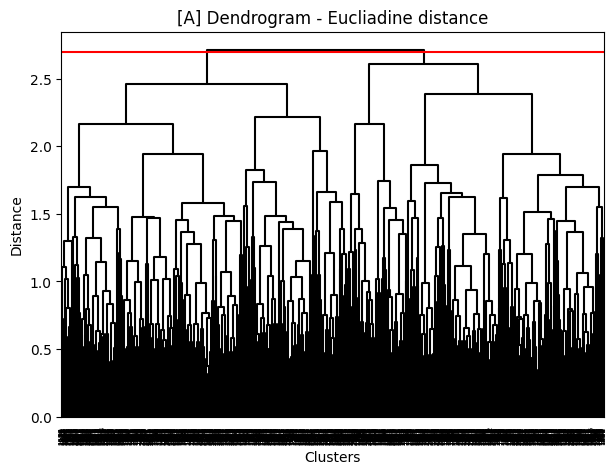

In [ ]:
# Dataset - potencials features discriminatory
features = ['MMSE', 'FunctionalAssessment', 'ADL', 'MemoryComplaints', 'BehavioralProblems']
df = data_fil[features].copy()
df_f = data_fil[features + ['Diagnosis']].copy() # features + label - purity calculation


scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['MMSE','FunctionalAssessment','ADL']] = scaler.fit_transform(df_scaled[['MMSE','FunctionalAssessment','ADL']])

# Eucliadine distance

euclid_dist = pdist(df_scaled, metric='euclidean')
euclid_dist_matrix = squareform(euclid_dist)

print(f"Matriz de distância Euclidiana calculada com formato: {euclid_dist_matrix.shape}")

# ==============================================================
# Hierarchical Grouping 1


# Medium Linkage
Z = linkage(euclid_dist, method='average')

max_d = 2.7  # cutoff
df['Cluster_Hierarquico_Eucli'] = fcluster(Z, max_d, criterion='distance')

n_clusters = df['Cluster_Hierarquico_Eucli'].nunique()
print(f"Clusters formados: {n_clusters}")
display(df.head())

# Dendrogram
plt.figure(figsize=(7, 5))
dendrogram(Z, labels=df.index, leaf_rotation=90, color_threshold=0,
           above_threshold_color='k')
plt.axhline(y=max_d, color='r', linestyle='solid', label=f'Corte = {max_d}')
plt.title("[A] Dendrogram - Eucliadine distance")
plt.xlabel("Clusters")
plt.ylabel("Distance")
plt.show()

In [ ]:
# intra - cluster distance
intra_dist = []
for cluster in range(1, n_clusters + 1):
    indices = np.where(df['Cluster_Hierarquico_Eucli'] == cluster)[0]
    if len(indices) > 1:
        sub_dist = euclid_dist_matrix[np.ix_(indices, indices)]
        mean_intra = (sub_dist.sum() - np.trace(sub_dist)) / (len(indices) * (len(indices) - 1))
        intra_dist.append(mean_intra)
    else:
        intra_dist.append(0)

print(f"Intra-cluster distances per cluster: {intra_dist}")
print(f"Average intra-cluster distances: {np.mean(intra_dist):.3f}")

# ==============================================================
# inter - cluster distance

inter_dist = []
for c1 in range(1, n_clusters + 1):
    for c2 in range(c1 + 1, n_clusters + 1):
        idx1 = np.where(df['Cluster_Hierarquico_Eucli'] == c1)[0]
        idx2 = np.where(df['Cluster_Hierarquico_Eucli'] == c2)[0]
        sub_dist = euclid_dist_matrix[np.ix_(idx1, idx2)]
        inter_dist.append(sub_dist.mean())

print(f"Inter-cluster distances between clusters: {inter_dist}")
print(f"Average intra-cluster distances: {np.mean(inter_dist):.3f}")

# purity calculation
df_f['Cluster_Hierarquico_Eucli'] = df['Cluster_Hierarquico_Eucli']
if 'Diagnosis' in df_f.columns:
    total = len(df_f)
    purity_sum = 0
    cluster_purity = {}

    for cluster in range(1, n_clusters + 1):
        indices = df_f['Cluster_Hierarquico_Eucli'] == cluster
        true_labels = df_f.loc[indices, 'Diagnosis']

        if len(true_labels) == 0:
            continue

        most_common = true_labels.value_counts().max()
        purity_cluster = most_common / len(true_labels)

        cluster_purity[cluster] = purity_cluster

        purity_sum += most_common

    purity_total = purity_sum / total

    print("Individual purity per cluster:")
    for c, p in cluster_purity.items():
        print(f"  Cluster {c}: {p:.3f}")

    print(f"\nTotal purity: {purity_total:.3f}")

else:
    print("No true label ('Diagnosis') was found for purity calculation.")

Intra-cluster distances per cluster: [np.float64(2.124280493020708), np.float64(2.1934578123382105)]
Average intra-cluster distances: 2.159
Inter-cluster distances between clusters: [np.float64(2.711510332237812)]
Average intra-cluster distances: 2.712
Individual purity per cluster:
  Cluster 1: 0.503
  Cluster 2: 0.808

Total purity: 0.646


#  Hierarchical Grouping 2 - Gower + complete

 Matriz de distância de Gower calculada com formato: (2149, 2149)


/tmp/ipython-input-2233586852.py:15: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method='complete')


Clusters formados: 2


,MMSE,FunctionalAssessment,ADL,MemoryComplaints,BehavioralProblems,Cluster_Hierarquico_gower
0,21.463532,6.518877,1.725883,0,0,1
1,20.613267,7.118696,2.592424,0,0,1
2,7.356249,5.895077,7.119548,0,0,1
3,13.991127,8.965106,6.481226,0,1,2
4,13.517609,6.045039,0.014691,0,0,1


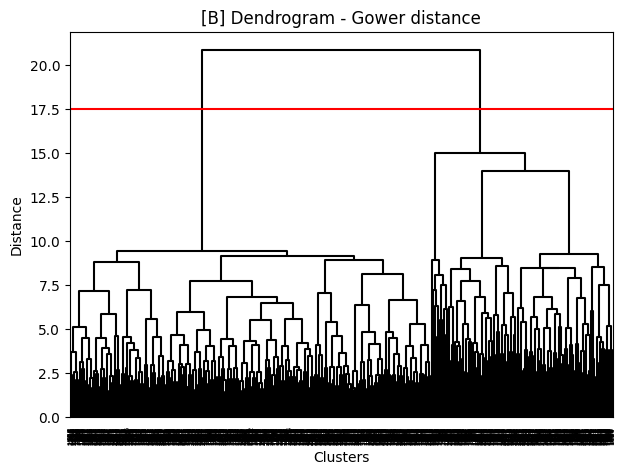

In [ ]:
# Dataset - potencials features discriminatory
features = ['MMSE', 'FunctionalAssessment', 'ADL', 'MemoryComplaints', 'BehavioralProblems']
df1 = data_fil[features].copy()
df_f1 = data_fil[features + ['Diagnosis']].copy() # features + rótulo para calcular a pureza

# Gower distance
gower_dist = gower.gower_matrix(df1)

print(f" Matriz de distância de Gower calculada com formato: {gower_dist.shape}")

# ==============================================================
# Hierarchical Grouping 2

# complete linkage
Z = linkage(gower_dist, method='complete')


max_d = 17.5  # cutoff
df1['Cluster_Hierarquico_gower'] = fcluster(Z, max_d, criterion='distance')

n_clusters = df1['Cluster_Hierarquico_gower'].nunique()
print(f"Clusters formados: {n_clusters}")
display(df1.head())


# Dendrogram
plt.figure(figsize=(7, 5))
dendrogram(Z, labels=df1.index, leaf_rotation=90,color_threshold=0,
           above_threshold_color='k')
plt.axhline(y=max_d, color='r', linestyle='solid', label=f'Corte = {max_d}')
plt.title("[B] Dendrogram - Gower distance")
plt.xlabel("Clusters")
plt.ylabel("Distance")
plt.show()

In [ ]:
# intra - cluster distance
intra_dist = []
for cluster in range(1, n_clusters+1):
    indices = np.where(df1['Cluster_Hierarquico_gower'] == cluster)[0]
    if len(indices) > 1:
        sub_dist = gower_dist[np.ix_(indices, indices)]
        mean_intra = (sub_dist.sum() - np.trace(sub_dist)) / (len(indices)*(len(indices)-1))
        intra_dist.append(mean_intra)
    else:
        intra_dist.append(0)
print(f"Intra-cluster distance per cluster: {intra_dist}")
print(f"Average intra-cluster distance: {np.mean(intra_dist):.3f}")

# ==============================================================
# inter - cluster distance

inter_dist = []
for c1 in range(1, n_clusters+1):
    for c2 in range(c1+1, n_clusters+1):
        idx1 = np.where(df1['Cluster_Hierarquico_gower']==c1)[0]
        idx2 = np.where(df1['Cluster_Hierarquico_gower']==c2)[0]
        sub_dist = gower_dist[np.ix_(idx1, idx2)]
        inter_dist.append(sub_dist.mean())
print(f"Inter-cluster distances between clusters: {inter_dist}")
print(f"Average inter-cluster distance: {np.mean(inter_dist):.3f}")

# purity calculation
df_f1['Cluster_Hierarquico_gower'] = df1['Cluster_Hierarquico_gower']
if 'Diagnosis' in df_f1.columns:
    total = len(df_f1)
    purity_sum = 0
    cluster_purity = {}

    for cluster in range(1, n_clusters + 1):
        indices = df_f1['Cluster_Hierarquico_gower'] == cluster
        true_labels = df_f1.loc[indices, 'Diagnosis']

        if len(true_labels) == 0:
            continue

        most_common = true_labels.value_counts().max()
        purity_cluster = most_common / len(true_labels)

        cluster_purity[cluster] = purity_cluster

        purity_sum += most_common

    purity_total = purity_sum / total


    print("Individual purity per cluster")
    for c, p in cluster_purity.items():
        print(f"  Cluster {c}: {p:.3f}")

    print(f"\nTotal purity: {purity_total:.3f}")

else:
    print("No true label ('Diagnosis') was found for purity calculation.")


Intra-cluster distance per cluster: [np.float32(0.20141086), np.float32(0.39499387)]
Average intra-cluster distance: 0.298
Inter-cluster distances between clusters: [np.float32(0.41989923)]
Average inter-cluster distance: 0.420
Individual purity per cluster
  Cluster 1: 0.772
  Cluster 2: 0.604

Total purity: 0.716


#  Hierarchical Grouping 3 - Hamming - complete

Clusters formados: 2


,MemoryComplaints,BehavioralProblems,Cluster_Hierarquico_Hamm
0,0,0,2
1,0,0,2
2,0,0,2
3,0,1,2
4,0,0,2


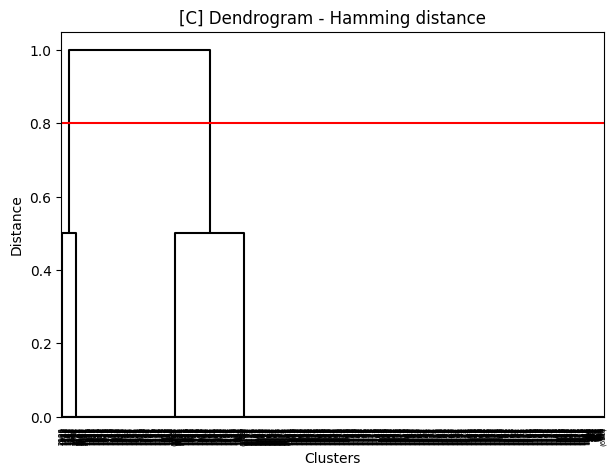

In [ ]:
# Dataset - potencials features discriminatory
features = ['MemoryComplaints', 'BehavioralProblems']
df2 = data_fil[features].copy()
df_f2 = data_fil[features + ['Diagnosis']].copy()

# Ensure that binary data is an integer
df2 = df2.astype(int)

# ==============================
# Hamming Distance

dist_hamming = pdist(df2, metric='hamming')
dist_square = squareform(dist_hamming)

# ==============================================================
# Hierarchical Grouping 3

# Complete linkage

Z = linkage(dist_hamming, method='complete')

max_d = 0.8  # # cutoff
df2['Cluster_Hierarquico_Hamm'] = fcluster(Z, max_d, criterion='distance')

n_clusters = df2['Cluster_Hierarquico_Hamm'].nunique()
print(f"Clusters formados: {n_clusters}")
display(df2.head())

# Dendrogram

plt.figure(figsize=(7,5))
dendrogram(Z, labels=df2.index, leaf_rotation=90,truncate_mode='lastp', p=1200,
           color_threshold=0,above_threshold_color='k')
plt.axhline(y=max_d, color='r', linestyle='solid', label=f'Corte = {max_d}')
plt.title("[C] Dendrogram - Hamming distance")
plt.xlabel("Clusters")
plt.ylabel("Distance")
plt.show()


In [ ]:
# Intra-cluster distance
intra_dist = []

for cluster in range(1, n_clusters+1):
    idx = np.where(df2['Cluster_Hierarquico_Hamm'] == cluster)[0]
    if len(idx) > 1:
        sub_dist = dist_square[np.ix_(idx, idx)]
        mean_intra = np.mean(sub_dist[np.triu_indices(len(idx), k=1)])
        intra_dist.append(mean_intra)
    else:
        intra_dist.append(np.nan)

print(f"Intra-cluster distance per cluster: {intra_dist}")
print(f"Average intra-cluster distance: {np.nanmean(intra_dist):.3f}")

# Inter - cluster distance
inter_dist = []

for c1 in range(1, n_clusters+1):
    for c2 in range(c1+1, n_clusters+1):
        idx1 = np.where(df2['Cluster_Hierarquico_Hamm'] == c1)[0]
        idx2 = np.where(df2['Cluster_Hierarquico_Hamm'] == c2)[0]
        sub_dist = dist_square[np.ix_(idx1, idx2)]
        inter_dist.append(sub_dist.mean())

print(f"Inter-cluster distances between clusters {inter_dist}")
print(f"Average inter-cluster distance: {np.mean(inter_dist):.3f}")

# purity calculation
df_f2['Cluster_Hierarquico_Hamm'] = df2['Cluster_Hierarquico_Hamm']

if 'Diagnosis' in df_f2.columns:
    total = len(df_f2)
    purity_sum = 0
    cluster_purity = {}

    for cluster in range(1, n_clusters + 1):
        indices = df_f2['Cluster_Hierarquico_Hamm'] == cluster
        true_labels = df_f2.loc[indices, 'Diagnosis']

        if len(true_labels) == 0:
            continue

        most_common = true_labels.value_counts().max()
        purity_cluster = most_common / len(true_labels)

        cluster_purity[cluster] = purity_cluster

        purity_sum += most_common

    purity_total = purity_sum / total


    print("Individual purity per cluster")
    for c, p in cluster_purity.items():
        print(f" Cluster {c}: {p:.3f}")

    print(f"\nTotal purity: {purity_total:.3f}")

else:
    print("No true label ('Diagnosis') was found for purity calculation.")

Intra-cluster distance per cluster: [np.float64(0.1277073865631364), np.float64(0.13354969876709008)]
Average intra-cluster distance: 0.131
Inter-cluster distances between clusters [np.float64(0.6304847304263703)]
Average inter-cluster distance: 0.630
Individual purity per cluster
 Cluster 1: 0.640
 Cluster 2: 0.722

Total purity: 0.705
